In [25]:
from astropy.io import ascii
import matplotlib.pyplot as plt
import numpy as np

In [26]:
data = ascii.read("FishVBM_Therr_m20_2_52.out")

In [27]:
event_126 = data[data["EventID"] == 126]
print(event_126)


EventID SubRun Field ... ObsGroup_0_Fbase2_err ObsGroup_0_fs2_err LCOutput
------- ------ ----- ... --------------------- ------------------ --------
    126      2    52 ...     0.000948879943335  0.001267401531059        1


In [28]:
lc_data = ascii.read("FishVBM_Therr_m20_2_52_126.det.lc")

In [29]:
def parse_prm_file(filepath):
    params = {}
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith("#") or "=" not in line:
                continue
            key, value = line.split("=", 1)
            params[key.strip()] = value.strip()
    return params

params = parse_prm_file("FVBM_m20.prm")

print(params)

{'RUN_NAME': 'FishVBM_Therr_m20', 'OUTPUT_DIR': '/work/fzohrabi/gulls_output/test/', 'FINAL_DIR': '/work/fzohrabi/gulls_output/test/', 'EXECUTABLE': 'gullsFish.x', 'OBSERVATORY_DIR': 'observatories/', 'OBSERVATORY_LIST': 'Roman_test_WZK.list', 'WEATHER_PROFILE_DIR': 'weather/', 'STARFIELD_DIR': 'starfields/', 'STARFIELD_LIST': 'gulls_surot2d_H2023.starfields', 'SOURCE_DIR': 'sources/', 'SOURCE_LIST': 'gulls_surot2d_H2023.sources', 'SOURCE_COLOURS': '0', 'LENS_DIR': 'lenses/', 'LENS_LIST': 'gulls_surot2d_H2023.lenses', 'LENS_COLOURS': '0', 'LENS_LIGHT': '1', 'PLANET_DIR': 'planet/m+20/', 'PLANET_ROOT': 'm+20.planets.', 'RATES_FILE': 'rates/src_gulls_surot2d_H2023.rates.v2', 'PRINCIPLE_OBSERVATORY': '0', 'OUTPUT_LC': '1', 'OUTPUT_IMAGES': '0', 'PRETTY_PICS': '0', 'PRETTY_PICS_DIMENSIONS': '128', 'OUTPUT_ONERR': '0', 'OUTPUT_ONDET': '1', 'OUTPUT_ONALL': '0', 'OUTPUT_FISH': '1', 'IDEAL_PHOTOMETRY': '-1', 'PARALLAX': '1', 'OBS_GROUPS': '(0,1,2)', 'NOBS': '3', 'NOBS_GROUPS': '1', 'OBS_GROUP_

In [30]:
sim_zero_time = float(params["SIMULATION_ZERO_TIME"])

## Sanity Check

In [31]:
#from .out file
row = event_126[0]  
t0_ref = row["t0lens1"]
tE = row["tE_ref"]
rho = row["rho"]
u0_list = [row["u0lens1"]]
alpha = row["alpha"]
q = row["Planet_q"]
s = row["Planet_s"]

t0 = abs(t0_ref - sim_zero_time)

In [32]:
#manually from data available from the .lc file
mask = lc_data['col6'] == 0 #0 is the data we need

# Extract positions
source_x = lc_data['col12'][mask]
source_y = lc_data['col13'][mask]
lens1_x = lc_data['col14'][mask]
lens1_y = lc_data['col15'][mask]
lens2_x = lc_data['col16'][mask]
lens2_y = lc_data['col17'][mask] 
bjd = lc_data["col11"][mask]



#Extract flux
flux = lc_data["col4"][mask]
flux_error = lc_data["col5"][mask]
#s
s_lc = lens2_x[0] - lens1_x[0]

#distance to lens
dist = np.sqrt((source_x - lens1_x)**2 + (source_y - lens1_y)**2)

#t0: time of closest approach
idx_min = np.argmin(dist)
t0_lc = bjd[idx_min]

#tE
ds = np.sqrt((source_x[-1] - source_x[0])**2 + (source_y[-1] - source_y[0])**2)
dt = bjd[-1] - bjd[0]
v = ds / dt
tE_lc = 1.0 / v  # in days

#tau
tau_lc = (bjd - t0_lc) / tE_lc

#alpha
dx = source_x[-1] - source_x[0]
dy = source_y[-1] - source_y[0]
alpha_rad = np.arctan2(dy, dx)
alpha_deg = np.degrees(alpha_rad) % 360  

#u0 parameter
x0 = source_x[len(source_x) // 2]
y0 = source_y[len(source_y) // 2]

numerator = abs(dx * y0 - dy * x0)
denominator = np.sqrt(dx**2 + dy**2)
u0_lc = numerator / denominator

print(f'Estimated s = {s_lc:.6},', f'GULLS output s={s}')
print(f'Estimated t0 = {t0_lc:.10},', f'GULLS output t0={t0}')
print(f'Estimated tE = {tE_lc:.6},', f'GULLS output tE={tE}')
print(f"Estimated alpha = {alpha_deg:.4f} degrees,", f'GULLS output alpha={alpha}')
print(f"Estimated u0 = {u0_lc:.6f},", f'GULLS output u0={u0_list}')

Estimated s = 1.34777, GULLS output s=1.347771197642
Estimated t0 = 2458261.929, GULLS output t0=2458206.0703329355
Estimated tE = 4.40305, GULLS output tE=4.403168559902
Estimated alpha = 274.3129 degrees, GULLS output alpha=274.3131637573
Estimated u0 = 0.086032, GULLS output u0=[np.float64(-0.08453353201416)]


## Comparing Model

In [33]:
from ML import TwoLens1S
model = TwoLens1S(t0=t0_lc, tE=tE, rho=rho, u0_list=u0_list, q=q, s=s, alpha=alpha, t_lc=bjd)
model2 = TwoLens1S(t0=t0_lc, tE=tE_lc, rho=rho, u0_list=[u0_lc], q=q, s=s_lc, alpha=alpha_deg, t_lc=bjd)


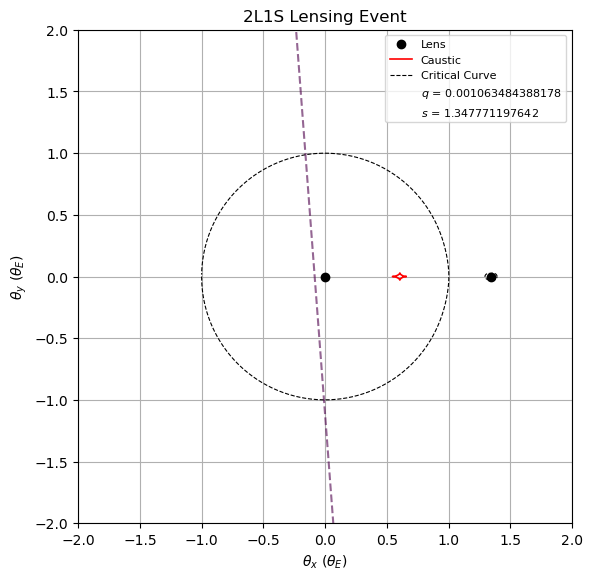

In [34]:
model.plot_caustic_critical_curves()

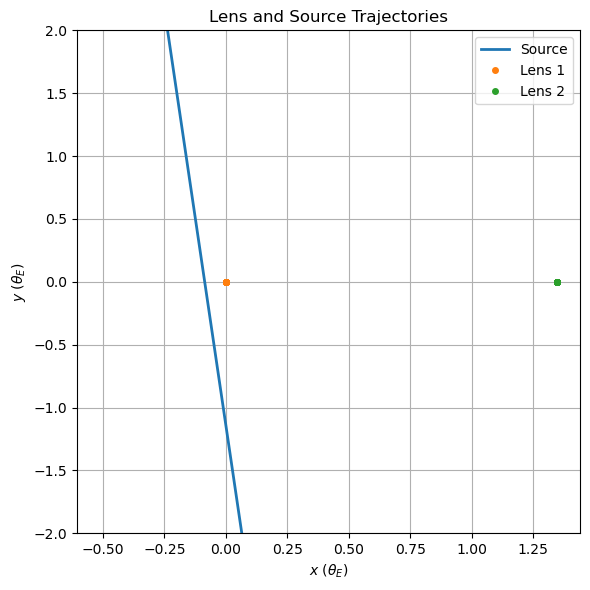

In [35]:
plt.figure(figsize=(6, 6))

# Plot source trajectory
plt.plot(source_x, source_y, label="Source", lw=2)

# Plot lens positions (assumed fixed)
plt.plot(lens1_x, lens1_y, 'o', label="Lens 1", markersize=4)
plt.plot(lens2_x, lens2_y, 'o', label="Lens 2", markersize=4)

plt.ylim(-2,2)
plt.xlabel(r"$x$ ($\theta_E$)")
plt.ylabel(r"$y$ ($\theta_E$)")
plt.title("Lens and Source Trajectories")
#plt.gca().set_aspect('equal')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [36]:
model_tau = model.tau_lc
model_mag = model.systems[0]["mag"]

model2_tau = model2.tau_lc
model2_mag = model2.systems[0]["mag"]

In [37]:
print(flux_error)

   col5   
----------
 0.0080608
0.00806081
0.00806081
0.00806082
0.00806082
0.00806083
0.00806083
0.00806084
0.00806084
0.00806084
       ...
0.00805845
0.00805845
0.00805845
0.00805845
0.00805845
0.00805845
0.00805845
0.00805845
0.00805845
0.00805845
Length = 6756 rows


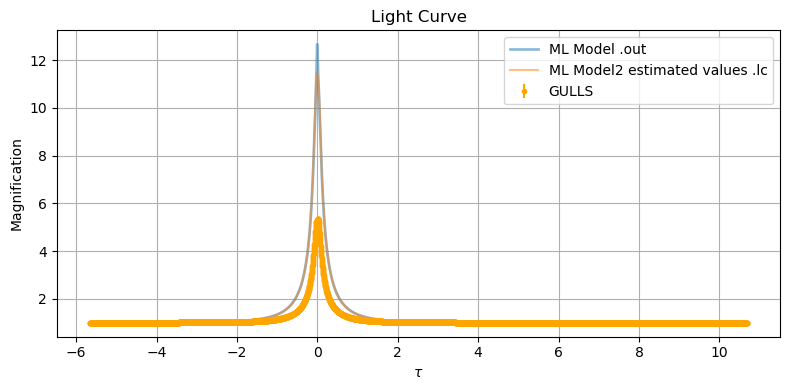

In [ ]:
plt.figure(figsize=(8, 4))
plt.errorbar(tau_lc, flux, label='GULLS', color='orange', yerr=flux_error, fmt='.')

plt.plot(model_tau, model_mag, label= "ML Model .out", lw=2, alpha = .5)
plt.plot(model2_tau, model2_mag, label ="ML Model2 estimated values .lc", alpha =.5)
plt.xlabel(r"$\tau$")
plt.ylabel("Magnification")
plt.title("Light Curve")


plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


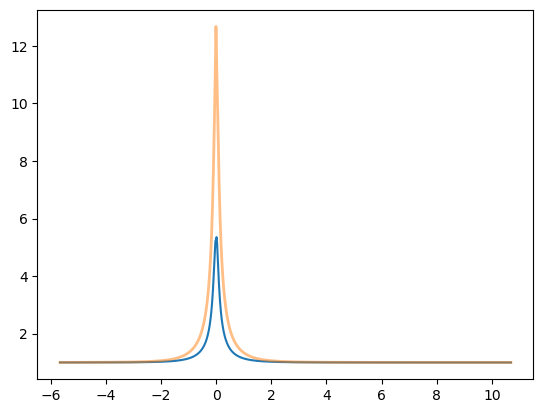

In [50]:
baseline = np.median(flux[tau_lc < -5])  # example: where far from event
magnification = flux / baseline

plt.plot(tau_lc, magnification, label='Re-normalized GULLS')
plt.plot(model_tau, model_mag, label= "ML Model .out", lw=2, alpha = .5)


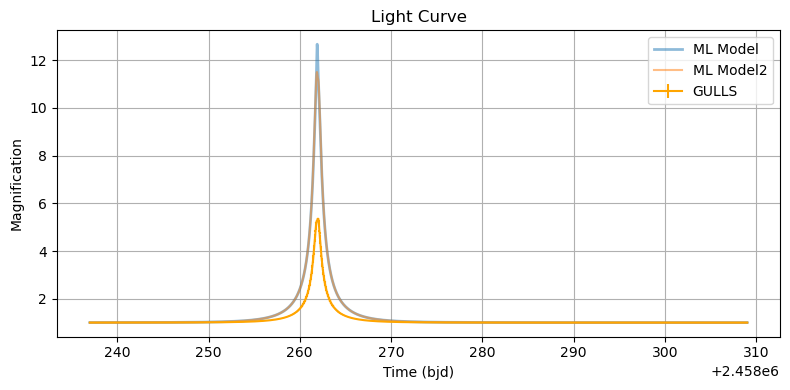

In [39]:
plt.figure(figsize=(8, 4))
plt.errorbar(bjd, flux, label='GULLS', color='orange', yerr=flux_error)
plt.plot(bjd, model_mag, label= "ML Model", lw=2, alpha = .5)
plt.plot(bjd, model2_mag, label ="ML Model2", alpha =.5)
plt.xlabel("Time (bjd)")
plt.ylabel("Magnification")
plt.title("Light Curve")

plt.xlim
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

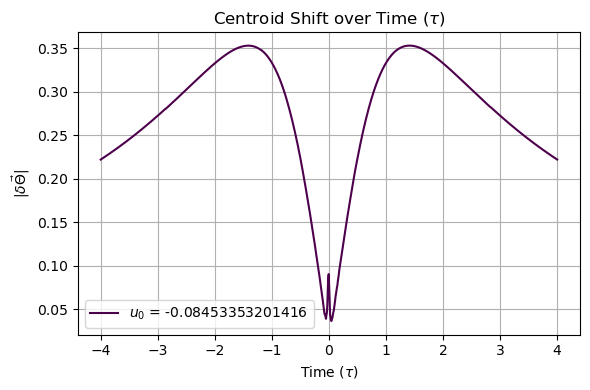

In [40]:
model.plot_centroid_shift()

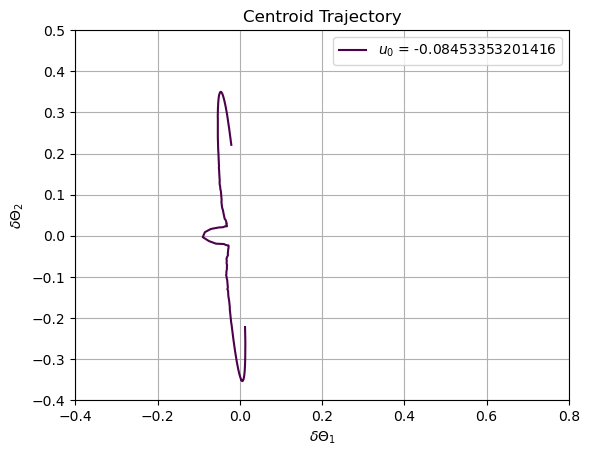

In [41]:
model.plot_centroid_trajectory()

# Checking VBM

In [42]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import VBMicrolensing

In [43]:
# Initialize VBMicrolensing() class object
VBM = VBMicrolensing.VBMicrolensing()
#Set relative accuracy
VBM.RelTol = 1e-03
#Set accuracy
VBM.Tol=1e-03

In [44]:
t = bjd
u0 = -0.08453353201416
alpha_r=np.radians(alpha)

print(alpha_r)

4.787667889127264


In [45]:
# Position of the center of the source with respect to the center of mass.
tau = (t - t0)/tE
y1 = -u0*np.sin(alpha) + tau_lc*np.cos(alpha)
y2 = u0*np.cos(alpha) + tau_lc*np.sin(alpha)

mag = np.zeros(len(tau))


params = [np.log(s), np.log(q), u0, alpha_r, np.log(rho), np.log(tE), t0]
mag = VBM.BinaryLightCurve(params, t)

In [46]:
print(tau)

      col11       
------------------
 7.026211725430777
 7.028535120476304
7.0308584927843025
 7.033181865092301
 7.035505237400299
 7.040151982122051
 7.042475354430049
 7.044798726738048
 7.047122099046046
   7.0494454714598
               ...
 23.35256240260052
23.354885775014274
23.357209147322273
23.361855891938266
23.364179264246264
23.366502659291793
 23.36882603170555
23.371149404013547
23.373472776321545
23.375796148629544
Length = 6756 rows


In [47]:
# Calculate the cirtical curves and the caustic curves
caustics = VBM.Caustics(s,q)

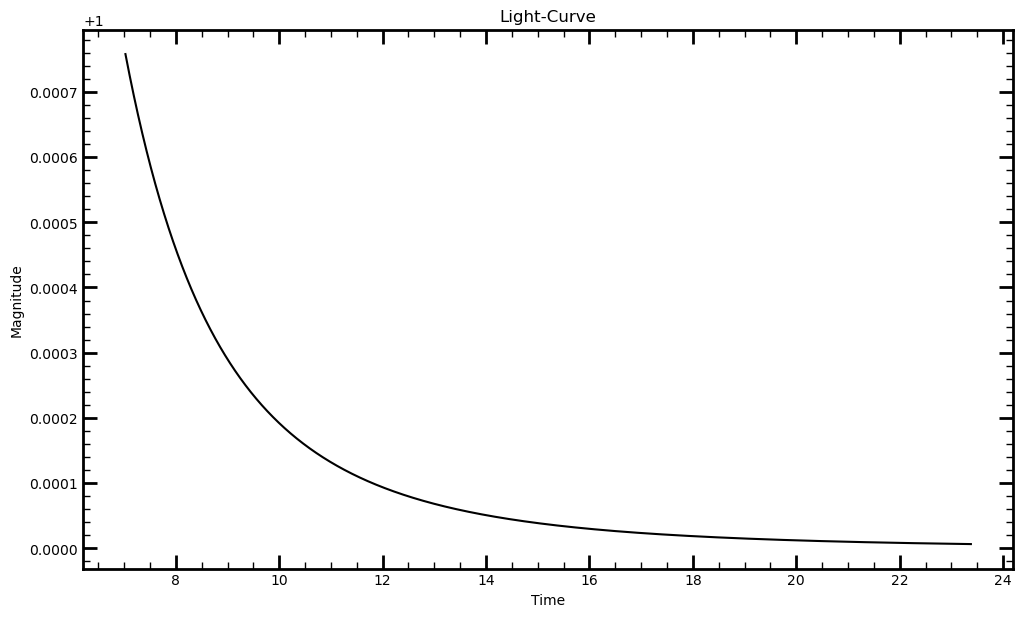

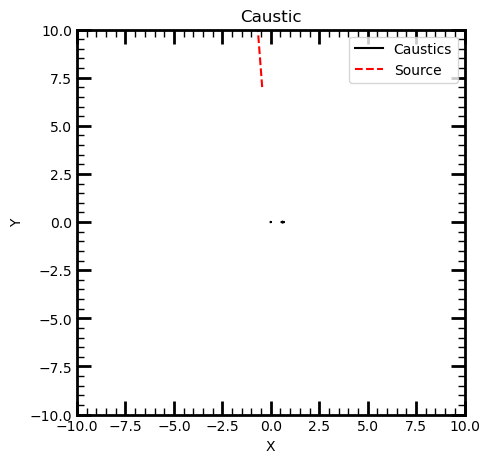

In [48]:
# LIGHT CURVE plot
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(tau, (mag[0]), 'k-')
ax.set_title('Light-Curve')
ax.set_xlabel('Time')          
ax.set_ylabel('Magnitude')
ax.minorticks_on()  # Aggiungi tick minori

ax.tick_params(axis='both', which='major', width=2, length=10, direction='in', bottom=True, top=True, left=True, right=True)
ax.tick_params(axis='both', which='minor', width=1, length=5, direction='in', bottom=True, top=True, left=True, right=True)

for spine in ax.spines.values():
    spine.set_linewidth(2)

# CAUSTICS plot
fig2 = plt.figure(figsize=(5, 5))
ax2 = fig2.add_subplot(111)

first_plot = True
for cau in caustics:
    if first_plot:
        ax2.plot(cau[0], cau[1], 'k-', markersize=0.1, label='Caustics')
        first_plot = False
    else:
        ax2.plot(cau[0], cau[1], 'k-', markersize=0.1)
        
ax2.plot(mag[1], mag[2], 'r--', label='Source')

mid_x = np.mean(mag[1])
mid_y = np.mean(mag[2])
delta_x = mag[1][-1] - mag[1][0]
delta_y = mag[2][-1] - mag[2][0]
arrow_end_x = mid_x + delta_x * 0.001
arrow_end_y = mid_y + delta_y * 0.001
ax2.annotate('', xy=(arrow_end_x, arrow_end_y), xytext=(mid_x, mid_y),
             arrowprops=dict(arrowstyle='->', color='red', mutation_scale=15, linestyle='-', linewidth=3))

ax2.set_xlim(-10, 10)
ax2.set_ylim(-10, 10)
ax2.set_title('Caustic')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.minorticks_on()  
ax2.legend()

ax2.tick_params(axis='both', which='major', width=2, length=10, direction='in', bottom=True, top=True, left=True, right=True)
ax2.tick_params(axis='both', which='minor', width=1, length=5, direction='in', bottom=True, top=True, left=True, right=True)

for spine in ax2.spines.values():
    spine.set_linewidth(2)

plt.show()